# Cassava leaf with mobilenet and adamax

## 1) Importing the libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import json
import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

## 2) Loading and summarizing data and creating data pipelines

In [2]:
data, dataset_info = tfds.load('cassava', split='train+test+validation', as_supervised = True, with_info = True)
datalen = [i for i,_ in enumerate(data)][-1] + 1
datalen

train_split = int(0.6*datalen)
test_val_split = int(0.2*datalen)
test_val_split = int(0.2*datalen)

training_set = data.take(train_split)
test_set = data.skip(train_split)
validation_set = test_set.skip(test_val_split)
test_set = test_set.take(test_val_split)

dataset=training_set,validation_set,test_set

In [3]:
dataset_info

tfds.core.DatasetInfo(
    name='cassava',
    version=0.1.0,
    description='Cassava consists of leaf images for the cassava plant depicting healthy and
four (4) disease conditions; Cassava Mosaic Disease (CMD), Cassava Bacterial
Blight (CBB), Cassava Greem Mite (CGM) and Cassava Brown Streak Disease (CBSD).
Dataset consists of a total of 9430 labelled images.
The 9430 labelled images are split into a training set (5656), a test set(1885)
and a validation set (1889). The number of images per class are unbalanced with
the two disease classes CMD and CBSD having 72% of the images.',
    homepage='https://www.kaggle.com/c/cassava-disease/overview',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    total_num_examples=9430,
    splits={
        'test': 1885,
        'train': 5656,
        'validation': 1889,
 

### From the above datset_info we can see that the data is split into train, test and validation batches and each image has features like filename, label and image itself(255 pixels) which can be harnessed whenever needed

In [4]:
total_examples = dataset_info.splits['train'].num_examples + dataset_info.splits['test'].num_examples + dataset_info.splits['validation'].num_examples

num_training_examples = train_split
num_validation_examples = test_val_split
num_test_examples = num_validation_examples

print('There are {:,} images in the training set'.format(num_training_examples))
print('There are {:,} images in the validation set'.format(num_validation_examples))
print('There are {:,} images in the test set'.format(num_test_examples))

num_classes = dataset_info.features['label'].num_classes
print('There are {:,} classes in our dataset'.format(num_classes))

There are 5,658 images in the training set
There are 1,886 images in the validation set
There are 1,886 images in the test set
There are 5 classes in our dataset


In [5]:
def resize(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [224,224], preserve_aspect_ratio=False)
    image /= 255
    return image, label

batch_size = 32
image_size = 224

training_batches = training_set.cache().shuffle(num_training_examples//4).map(resize).batch(batch_size).prefetch(1)
validation_batches = validation_set.cache().map(resize).batch(batch_size).prefetch(1)
testing_batches = test_set.cache().map(resize).batch(batch_size).prefetch(1)

## 3) Creating models, plots and test data evaluation

In [6]:
pretrained_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

In [7]:
lr = 0.001

decay_steps = 100000
decay_rate = 0.95

exp_lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(lr, decay_steps, decay_rate)

In [8]:
def plotter(history):
    training_accuracy = history.history['accuracy']
    validation_accuracy = history.history['val_accuracy']
 
    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']

    epochs_range=range(EPOCHS)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
    plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, training_loss, label='Training Loss')
    plt.plot(epochs_range, validation_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [9]:
def summary_plot(pretrained_model,losses,accuracies):
    plt.figure(figsize=(8, 8))
    
    plt.subplot(1, 2, 1)
    plt.plot(all_optimizers, losses)
    plt.xlabel("Gradient Descent Variants")
    plt.ylabel("Loss Values")
    plt.title('Testing Loss Summary')

    plt.subplot(1, 2, 2)
    plt.bar(all_optimizers, accuracies)
    plt.xlabel("Gradient Descent Variants")
    plt.ylabel("Accuracy Values")
    plt.title('Testing Accuracy Summary')
    
    plt.show()
    

Epoch 1/25
177/177 [==============================] - 113s 639ms/step - loss: 1.0141 - accuracy: 0.6214 - val_loss: 0.8515 - val_accuracy: 0.6872
Epoch 2/25
177/177 [==============================] - 106s 602ms/step - loss: 0.8128 - accuracy: 0.7024 - val_loss: 0.7905 - val_accuracy: 0.7078
Epoch 3/25
177/177 [==============================] - 107s 602ms/step - loss: 0.7527 - accuracy: 0.7216 - val_loss: 0.7414 - val_accuracy: 0.7216
Epoch 4/25
177/177 [==============================] - 109s 615ms/step - loss: 0.7118 - accuracy: 0.7423 - val_loss: 0.7202 - val_accuracy: 0.7285
Epoch 5/25
177/177 [==============================] - 107s 602ms/step - loss: 0.6838 - accuracy: 0.7517 - val_loss: 0.7022 - val_accuracy: 0.7328
Epoch 6/25
177/177 [==============================] - 107s 603ms/step - loss: 0.6625 - accuracy: 0.7637 - val_loss: 0.6945 - val_accuracy: 0.7450
Epoch 7/25
177/177 [==============================] - 106s 600ms/step - loss: 0.6441 - accuracy: 0.7717 - val_loss: 0.6865 -

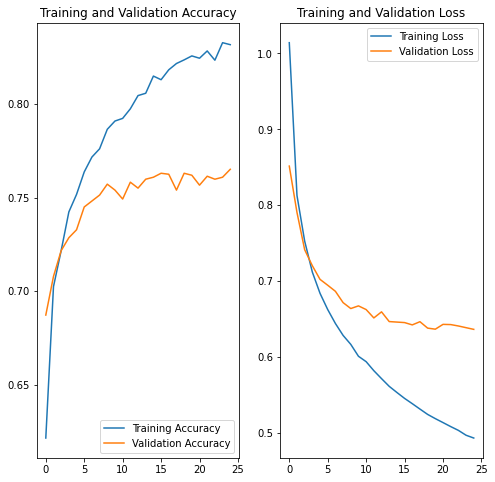

59/59 [==============================] - 28s 467ms/step - loss: 0.6321 - accuracy: 0.7630

Loss on the TEST Set: 0.632

Accuracy on the TEST Set: 76.299%


In [10]:
EPOCHS = 25

feature_extractor = hub.KerasLayer(pretrained_model, input_shape=(image_size, image_size,3))
feature_extractor.trainable = False
model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(num_classes, activation ='softmax')])
    
           
model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=exp_lr_scheduler),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
        

history = model.fit(training_batches,
                    epochs = EPOCHS,
                    validation_data=validation_batches) 
        

        
plotter(history)
        
loss, accuracy = model.evaluate(testing_batches)
        
       
print('\nLoss on the TEST Set: {:,.3f}'.format(loss))
print('\nAccuracy on the TEST Set: {:.3%}'.format(accuracy))
        
    